# Worksheet 17

Name: Naif Albalawi, Rithvik Nakirikanti, Sadiq Alhumood, Ali Almatrood
UID:

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.


We can start by collecting and preprocessing user interaction data, converting likes and dislikes into binary values of 0 and 1. Extract relevant features from this data, such as user demographics or item genres, to measure similarity between users or items. Use these similarities to generate recommendations via collaborative filtering techniques like user-based or item-based filtering. Evaluate the system's performance using metrics like precision or recall, and continuously iterate and improve the system by incorporating user feedback and monitoring its performance.

b) Describe 3 challenges of building a recommender system

3 challenges of building a recommender system include dealing with sparse data, handling the cold start problem, and ensuring diversity in recommendations. Sparse data occurs because users typically interact with only a small subset of available items, making it difficult to generate accurate suggestions. The cold start problem involves difficulty in recommending items to new users or new items to existing users due to a lack of historical interaction data. Lastly, maintaining diversity in recommendations is crucial to prevent users from being trapped in a filter bubble where they see only similar items, which can diminish user experience and engagement. Addressing these challenges effectively is crucial for developing a recommender system that is both useful and engaging for users.

c) Why is SVD not an option for collaborative filtering?

SVD requires a complete matrix of user-item ratings. However, in collaborative filtering, it is common to have sparse matrices where most of the entries are missing. SVD cannot handle missing values and requires a dense matrix, making it impractical for collaborative filtering.

d) Use the code below to train a recommender system on a dataset of amazon movies

Kaggle RMSE = 1.4438411718871067


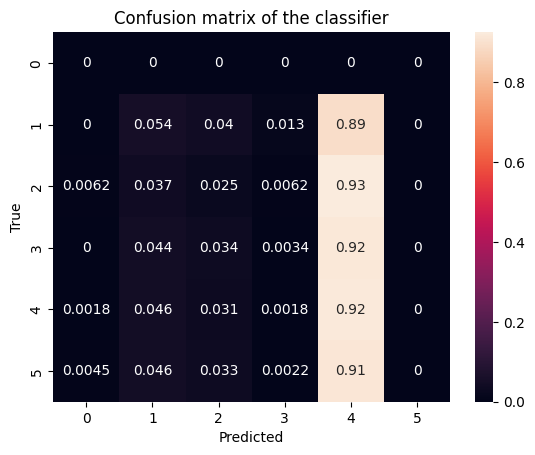

In [ ]:
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize PySpark
findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()


init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes


X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
    init_df[['UserId_fact', 'ProductId_fact']],
    init_df['Score'],
    test_size=1/4.0,
    random_state=0
)
X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed)
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 50]) \
    .addGrid(als.regParam, [0.1]) \
    .addGrid(als.maxIter, [10]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Score")

cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys = als.fit(df)  # Use this line instead of CV if not using Grid Search
X_test_processed_spark = spark.createDataFrame(X_test_processed)
rec = rec_sys.transform(X_test_processed_spark).toPandas()

X_test_processed['id'] = range(len(X_test_processed))
rec['id'] = rec.index
result_df = pd.merge(X_test_processed, rec, on='id', how='left')
mean_score = Y_train.mean()
result_df['prediction'].fillna(mean_score, inplace=True)
X_test_processed['Predicted_Score'] = result_df['prediction'].values


print("Kaggle RMSE =", mean_squared_error(Y_test, X_test_processed['Predicted_Score'], squared=False))
cm = confusion_matrix(Y_test, X_test_processed['Predicted_Score'].round(), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

